# Testing the effect of incorporating observed information

We test the effect on SGHMC of using observed information to estimate the noise model. We test three configurations:
- Not using observed information.
- Only calculating the estimate at setup time.
- Recalculating every sample.
- Recalculating before every step while simulating the dynamics in a sample.

We record the test accuracy and time taken for each sample.

In [4]:
import sys
sys.path.append("..")

import os.path
import json

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC
from kernel.sgld import SGLD
from kernel.sgd import SGD
from kernel.sgnuts import NUTS as SGNUTS

pyro.set_rng_seed(101)

plt.rcParams['figure.dpi'] = 300

In [ ]:
# assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
device = torch.device("cpu")

In [6]:
RESULTS_DIR = os.path.join("results", "obs-info")
RESULTS_NOINFO = os.path.join(RESULTS_DIR, "noinfo.json")
RESULTS_START = os.path.join(RESULTS_DIR, "start.json")
RESULTS_EVERY_SAMPLE = os.path.join(RESULTS_DIR, "every-sample.json")
RESULTS_EVERY_STEP = os.path.join(RESULTS_DIR, "every-step.json")

In [ ]:
# Simple dataset wrapper class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

## Hyperparams

These hyperparameters were fixed during the hyperparameter search. All other hyperparameters in this notebook are the best ones we found during the hyperparameter search.

In [9]:
BATCH_SIZE = 500
NUM_EPOCHS = 100
WARMUP_EPOCHS = 50
HIDDEN_SIZE = 100

## Download MNIST and setup datasets / dataloaders

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]
    
mean = 0.1307
std = 0.3081

# scale the datasets
X_train = train_dataset.data[train_idx] / 255.0
Y_train = train_dataset.targets[train_idx]

X_val = train_dataset.data[val_idx] / 255.0
Y_val = train_dataset.targets[val_idx]

X_test = test_dataset.data / 255.0
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define the Bayesian neural network  model

In [ ]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size, prec=1., device='cpu'):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting

        self.device = device
        
        # TODO add gamma priors to precision terms

        self.fc1 = PyroLinear(input_size, hidden_size)

        fc1_weight_loc = torch.zeros((hidden_size, input_size), device=self.device)
        fc1_weight_scale = torch.ones((hidden_size, input_size), device=self.device) * prec

        fc1_bias_loc = torch.zeros((hidden_size,), device=self.device)
        fc1_bias_scale = torch.ones((hidden_size,), device=self.device) * prec

        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(fc1_weight_loc, fc1_weight_scale).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(fc1_bias_loc, fc1_bias_scale).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)

        fc2_weight_loc = torch.zeros((output_size, hidden_size), device=self.device)
        fc2_weight_scale = torch.ones((output_size, hidden_size), device=self.device) * prec

        fc2_bias_loc = torch.zeros((output_size,), device=self.device)
        fc2_bias_scale = torch.ones((output_size,), device=self.device) * prec

        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(fc2_weight_loc, fc2_weight_scale).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(fc2_bias_loc, fc2_bias_scale).to_event(1))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28).to(self.device)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class

        if y is not None:
            y = y.to(self.device)
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

## Not using observed information

In [8]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1 # fixed during hypeparameter search

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10, device=device).to(device)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N,
              obs_info_noise=False,
              device=device)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

noinfo_test_errs = []
noinfo_times = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    
    start = time.time()

    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                prediction = predictive(x)['obs'].to(torch.int64).to("cpu")
                if epoch_predictive is None:
                    epoch_predictive = prediction
                else:
                    epoch_predictive = torch.cat((epoch_predictive, prediction), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        noinfo_test_errs.append(1.0 - correct/total)
        noinfo_times.append(end - start)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

# Save the errors to a file
with open(RESULTS_NOINFO, "w") as f:
    json.dump((noinfo_test_errs, noinfo_times), f)

Sample: 100%|██████████████████████████| 100/100 [00:06, 15.69it/s, lr=2.00e-06]


Epoch [0/100] test accuracy: 0.9166 time: 14.09


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.82it/s, lr=2.00e-06]


Epoch [1/100] test accuracy: 0.9188 time: 13.81


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.44it/s, lr=2.00e-06]


Epoch [2/100] test accuracy: 0.9197 time: 14.20


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.33it/s, lr=2.00e-06]


Epoch [3/100] test accuracy: 0.9197 time: 14.41


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.09it/s, lr=2.00e-06]


Epoch [4/100] test accuracy: 0.9211 time: 14.40


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.23it/s, lr=2.00e-06]


Epoch [5/100] test accuracy: 0.9212 time: 14.11


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.99it/s, lr=2.00e-06]


Epoch [6/100] test accuracy: 0.9209 time: 13.59


Sample: 100%|██████████████████████████| 100/100 [00:06, 15.93it/s, lr=2.00e-06]


Epoch [7/100] test accuracy: 0.9220 time: 14.29


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.50it/s, lr=2.00e-06]


Epoch [8/100] test accuracy: 0.9220 time: 13.59


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.56it/s, lr=2.00e-06]


Epoch [9/100] test accuracy: 0.9227 time: 14.32


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.61it/s, lr=2.00e-06]


Epoch [10/100] test accuracy: 0.9238 time: 12.90


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.74it/s, lr=2.00e-06]


Epoch [11/100] test accuracy: 0.9242 time: 13.21


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.95it/s, lr=2.00e-06]


Epoch [12/100] test accuracy: 0.9238 time: 13.67


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.41it/s, lr=2.00e-06]


Epoch [13/100] test accuracy: 0.9243 time: 14.04


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.53it/s, lr=2.00e-06]


Epoch [14/100] test accuracy: 0.9254 time: 13.30


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.79it/s, lr=2.00e-06]


Epoch [15/100] test accuracy: 0.9260 time: 12.76


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.22it/s, lr=2.00e-06]


Epoch [16/100] test accuracy: 0.9270 time: 13.71


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.59it/s, lr=2.00e-06]


Epoch [17/100] test accuracy: 0.9279 time: 14.00


Sample: 100%|██████████████████████████| 100/100 [00:06, 15.82it/s, lr=2.00e-06]


Epoch [18/100] test accuracy: 0.9279 time: 13.71


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.54it/s, lr=2.00e-06]


Epoch [19/100] test accuracy: 0.9285 time: 13.59


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.98it/s, lr=2.00e-06]


Epoch [20/100] test accuracy: 0.9291 time: 13.81


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.68it/s, lr=2.00e-06]


Epoch [21/100] test accuracy: 0.9296 time: 13.91


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.94it/s, lr=2.00e-06]


Epoch [22/100] test accuracy: 0.9301 time: 13.79


Sample: 100%|██████████████████████████| 100/100 [00:06, 15.23it/s, lr=2.00e-06]


Epoch [23/100] test accuracy: 0.9306 time: 14.00


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.06it/s, lr=2.00e-06]


Epoch [24/100] test accuracy: 0.9307 time: 13.90


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.95it/s, lr=2.00e-06]


Epoch [25/100] test accuracy: 0.9313 time: 13.90


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.56it/s, lr=2.00e-06]


Epoch [26/100] test accuracy: 0.9315 time: 13.56


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.88it/s, lr=2.00e-06]


Epoch [27/100] test accuracy: 0.9318 time: 13.25


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.38it/s, lr=2.00e-06]


Epoch [28/100] test accuracy: 0.9321 time: 12.96


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.16it/s, lr=2.00e-06]


Epoch [29/100] test accuracy: 0.9327 time: 13.41


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.33it/s, lr=2.00e-06]


Epoch [30/100] test accuracy: 0.9333 time: 13.91


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.02it/s, lr=2.00e-06]


Epoch [31/100] test accuracy: 0.9340 time: 13.80


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.37it/s, lr=2.00e-06]


Epoch [32/100] test accuracy: 0.9346 time: 12.59


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.20it/s, lr=2.00e-06]


Epoch [33/100] test accuracy: 0.9349 time: 13.98


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.19it/s, lr=2.00e-06]


Epoch [34/100] test accuracy: 0.9355 time: 13.81


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.71it/s, lr=2.00e-06]


Epoch [35/100] test accuracy: 0.9361 time: 13.71


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.94it/s, lr=2.00e-06]


Epoch [36/100] test accuracy: 0.9364 time: 13.57


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.56it/s, lr=2.00e-06]


Epoch [37/100] test accuracy: 0.9366 time: 13.92


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.21it/s, lr=2.00e-06]


Epoch [38/100] test accuracy: 0.9370 time: 13.59


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.98it/s, lr=2.00e-06]


Epoch [39/100] test accuracy: 0.9370 time: 13.51


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.60it/s, lr=2.00e-06]


Epoch [40/100] test accuracy: 0.9374 time: 13.88


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.67it/s, lr=2.00e-06]


Epoch [41/100] test accuracy: 0.9374 time: 13.80


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.97it/s, lr=2.00e-06]


Epoch [42/100] test accuracy: 0.9373 time: 13.82


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.97it/s, lr=2.00e-06]


Epoch [43/100] test accuracy: 0.9379 time: 13.90


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.91it/s, lr=2.00e-06]


Epoch [44/100] test accuracy: 0.9380 time: 13.60


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.96it/s, lr=2.00e-06]


Epoch [45/100] test accuracy: 0.9380 time: 13.11


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.98it/s, lr=2.00e-06]


Epoch [46/100] test accuracy: 0.9387 time: 13.57


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.12it/s, lr=2.00e-06]


Epoch [47/100] test accuracy: 0.9390 time: 13.94


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.70it/s, lr=2.00e-06]


Epoch [48/100] test accuracy: 0.9390 time: 13.69


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.20it/s, lr=2.00e-06]


Epoch [49/100] test accuracy: 0.9390 time: 13.58


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.12it/s, lr=2.00e-06]


Epoch [50/100] test accuracy: 0.9394 time: 13.72


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.75it/s, lr=2.00e-06]


Epoch [51/100] test accuracy: 0.9397 time: 13.81


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.76it/s, lr=2.00e-06]


Epoch [52/100] test accuracy: 0.9402 time: 13.79


Sample: 100%|██████████████████████████| 100/100 [00:06, 15.34it/s, lr=2.00e-06]


Epoch [53/100] test accuracy: 0.9402 time: 14.31


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.71it/s, lr=2.00e-06]


Epoch [54/100] test accuracy: 0.9405 time: 13.69


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.97it/s, lr=2.00e-06]


Epoch [55/100] test accuracy: 0.9409 time: 13.61


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.22it/s, lr=2.00e-06]


Epoch [56/100] test accuracy: 0.9409 time: 12.88


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.35it/s, lr=2.00e-06]


Epoch [57/100] test accuracy: 0.9411 time: 13.81


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.77it/s, lr=2.00e-06]


Epoch [58/100] test accuracy: 0.9417 time: 13.68


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.22it/s, lr=2.00e-06]


Epoch [59/100] test accuracy: 0.9421 time: 13.79


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.17it/s, lr=2.00e-06]


Epoch [60/100] test accuracy: 0.9423 time: 13.24


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.71it/s, lr=2.00e-06]


Epoch [61/100] test accuracy: 0.9428 time: 13.66


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.46it/s, lr=2.00e-06]


Epoch [62/100] test accuracy: 0.9431 time: 13.40


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.29it/s, lr=2.00e-06]


Epoch [63/100] test accuracy: 0.9432 time: 13.51


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.61it/s, lr=2.00e-06]


Epoch [64/100] test accuracy: 0.9435 time: 14.20


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.94it/s, lr=2.00e-06]


Epoch [65/100] test accuracy: 0.9437 time: 13.80


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.97it/s, lr=2.00e-06]


Epoch [66/100] test accuracy: 0.9438 time: 13.31


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.30it/s, lr=2.00e-06]


Epoch [67/100] test accuracy: 0.9439 time: 13.69


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.13it/s, lr=2.00e-06]


Epoch [68/100] test accuracy: 0.9444 time: 14.21


Sample: 100%|██████████████████████████| 100/100 [00:06, 15.82it/s, lr=2.00e-06]


Epoch [69/100] test accuracy: 0.9446 time: 13.81


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.67it/s, lr=2.00e-06]


Epoch [70/100] test accuracy: 0.9446 time: 13.80


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.39it/s, lr=2.00e-06]


Epoch [71/100] test accuracy: 0.9447 time: 12.90


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.98it/s, lr=2.00e-06]


Epoch [72/100] test accuracy: 0.9446 time: 12.88


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.64it/s, lr=2.00e-06]


Epoch [73/100] test accuracy: 0.9450 time: 13.68


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.92it/s, lr=2.00e-06]


Epoch [74/100] test accuracy: 0.9451 time: 13.30


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.22it/s, lr=2.00e-06]


Epoch [75/100] test accuracy: 0.9456 time: 13.41


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.90it/s, lr=2.00e-06]


Epoch [76/100] test accuracy: 0.9455 time: 13.88


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.84it/s, lr=2.00e-06]


Epoch [77/100] test accuracy: 0.9454 time: 13.61


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.55it/s, lr=2.00e-06]


Epoch [78/100] test accuracy: 0.9454 time: 12.90


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.55it/s, lr=2.00e-06]


Epoch [79/100] test accuracy: 0.9457 time: 12.93


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.68it/s, lr=2.00e-06]


Epoch [80/100] test accuracy: 0.9458 time: 13.40


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.45it/s, lr=2.00e-06]


Epoch [81/100] test accuracy: 0.9463 time: 13.90


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.89it/s, lr=2.00e-06]


Epoch [82/100] test accuracy: 0.9471 time: 12.49


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.21it/s, lr=2.00e-06]


Epoch [83/100] test accuracy: 0.9471 time: 13.09


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.62it/s, lr=2.00e-06]


Epoch [84/100] test accuracy: 0.9471 time: 13.80


Sample: 100%|██████████████████████████| 100/100 [00:06, 15.91it/s, lr=2.00e-06]


Epoch [85/100] test accuracy: 0.9473 time: 14.31


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.97it/s, lr=2.00e-06]


Epoch [86/100] test accuracy: 0.9474 time: 13.48


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.59it/s, lr=2.00e-06]


Epoch [87/100] test accuracy: 0.9478 time: 13.43


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.19it/s, lr=2.00e-06]


Epoch [88/100] test accuracy: 0.9484 time: 13.59


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.55it/s, lr=2.00e-06]


Epoch [89/100] test accuracy: 0.9486 time: 13.37


Sample: 100%|██████████████████████████| 100/100 [00:05, 16.70it/s, lr=2.00e-06]


Epoch [90/100] test accuracy: 0.9486 time: 13.04


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.25it/s, lr=2.00e-06]


Epoch [91/100] test accuracy: 0.9489 time: 13.52


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.24it/s, lr=2.00e-06]


Epoch [92/100] test accuracy: 0.9491 time: 13.61


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.63it/s, lr=2.00e-06]


Epoch [93/100] test accuracy: 0.9492 time: 13.80


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.37it/s, lr=2.00e-06]


Epoch [94/100] test accuracy: 0.9495 time: 13.38


Sample: 100%|██████████████████████████| 100/100 [00:06, 16.64it/s, lr=2.00e-06]


Epoch [95/100] test accuracy: 0.9496 time: 13.10


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.74it/s, lr=2.00e-06]


Epoch [96/100] test accuracy: 0.9497 time: 12.91


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.19it/s, lr=2.00e-06]


Epoch [97/100] test accuracy: 0.9502 time: 13.79


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.21it/s, lr=2.00e-06]


Epoch [98/100] test accuracy: 0.9509 time: 13.41


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.63it/s, lr=2.00e-06]


Epoch [99/100] test accuracy: 0.9509 time: 13.28


Sample: 100%|██████████████████████████| 100/100 [00:05, 17.43it/s, lr=2.00e-06]


Epoch [100/100] test accuracy: 0.9509 time: 13.82


## Estimating at setup time

In [8]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1 # fixed during hypeparameter search

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10, device=device).to(device)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N,
              obs_info_noise=True,
              compute_obs_info="start",
              device=device)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

start_test_errs = []
start_times = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    
    start = time.time()

    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                prediction = predictive(x)['obs'].to(torch.int64).to("cpu")
                if epoch_predictive is None:
                    epoch_predictive = prediction
                else:
                    epoch_predictive = torch.cat((epoch_predictive, prediction), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        start_test_errs.append(1.0 - correct/total)
        start_times.append(end - start)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

# Save the errors to a file
with open(RESULTS_START, "w") as f:
    json.dump((start_test_errs, start_times), f)

Sample: 100%|██████████████████████████| 100/100 [06:39,  3.99s/it, lr=2.00e-06]


Epoch [0/100] test accuracy: 0.9166 time: 443.40


Sample: 100%|██████████████████████████| 100/100 [06:40,  4.00s/it, lr=2.00e-06]


Epoch [1/100] test accuracy: 0.9188 time: 429.39


Sample: 100%|██████████████████████████| 100/100 [06:16,  3.76s/it, lr=2.00e-06]


Epoch [2/100] test accuracy: 0.9197 time: 407.44


Sample: 100%|██████████████████████████| 100/100 [06:16,  3.77s/it, lr=2.00e-06]


Epoch [3/100] test accuracy: 0.9197 time: 403.52


Sample: 100%|██████████████████████████| 100/100 [06:15,  3.76s/it, lr=2.00e-06]


Epoch [4/100] test accuracy: 0.9211 time: 413.89


Sample: 100%|██████████████████████████| 100/100 [06:21,  3.81s/it, lr=2.00e-06]


Epoch [5/100] test accuracy: 0.9212 time: 414.16


Sample: 100%|██████████████████████████| 100/100 [06:25,  3.85s/it, lr=2.00e-06]


Epoch [6/100] test accuracy: 0.9209 time: 414.30


Sample: 100%|██████████████████████████| 100/100 [06:18,  3.79s/it, lr=2.00e-06]


Epoch [7/100] test accuracy: 0.9220 time: 408.94


Sample: 100%|██████████████████████████| 100/100 [06:22,  3.82s/it, lr=2.00e-06]


Epoch [8/100] test accuracy: 0.9220 time: 407.96


Sample: 100%|██████████████████████████| 100/100 [06:16,  3.77s/it, lr=2.00e-06]


Epoch [9/100] test accuracy: 0.9227 time: 404.25


Sample: 100%|██████████████████████████| 100/100 [06:19,  3.80s/it, lr=2.00e-06]


Epoch [10/100] test accuracy: 0.9238 time: 402.50


Sample: 100%|██████████████████████████| 100/100 [06:29,  3.90s/it, lr=2.00e-06]


Epoch [11/100] test accuracy: 0.9242 time: 419.80


Sample: 100%|██████████████████████████| 100/100 [06:37,  3.97s/it, lr=2.00e-06]


Epoch [12/100] test accuracy: 0.9238 time: 426.85


Sample: 100%|██████████████████████████| 100/100 [06:30,  3.90s/it, lr=2.00e-06]


Epoch [13/100] test accuracy: 0.9243 time: 415.80


Sample: 100%|██████████████████████████| 100/100 [06:36,  3.97s/it, lr=2.00e-06]


Epoch [14/100] test accuracy: 0.9254 time: 423.24


Sample: 100%|██████████████████████████| 100/100 [06:29,  3.90s/it, lr=2.00e-06]


Epoch [15/100] test accuracy: 0.9260 time: 415.90


Sample: 100%|██████████████████████████| 100/100 [06:27,  3.87s/it, lr=2.00e-06]


Epoch [16/100] test accuracy: 0.9270 time: 411.06


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.88s/it, lr=2.00e-06]


Epoch [17/100] test accuracy: 0.9279 time: 415.90


Sample: 100%|██████████████████████████| 100/100 [06:26,  3.87s/it, lr=2.00e-06]


Epoch [18/100] test accuracy: 0.9279 time: 411.54


Sample: 100%|██████████████████████████| 100/100 [06:22,  3.83s/it, lr=2.00e-06]


Epoch [19/100] test accuracy: 0.9285 time: 408.85


Sample: 100%|██████████████████████████| 100/100 [06:32,  3.92s/it, lr=2.00e-06]


Epoch [20/100] test accuracy: 0.9291 time: 424.31


Sample: 100%|██████████████████████████| 100/100 [06:38,  3.98s/it, lr=2.00e-06]


Epoch [21/100] test accuracy: 0.9296 time: 425.00


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.88s/it, lr=2.00e-06]


Epoch [22/100] test accuracy: 0.9301 time: 409.56


Sample: 100%|██████████████████████████| 100/100 [06:29,  3.89s/it, lr=2.00e-06]


Epoch [23/100] test accuracy: 0.9306 time: 414.84


Sample: 100%|██████████████████████████| 100/100 [06:30,  3.90s/it, lr=2.00e-06]


Epoch [24/100] test accuracy: 0.9307 time: 414.96


Sample: 100%|██████████████████████████| 100/100 [06:30,  3.90s/it, lr=2.00e-06]


Epoch [25/100] test accuracy: 0.9313 time: 418.39


Sample: 100%|██████████████████████████| 100/100 [06:37,  3.97s/it, lr=2.00e-06]


Epoch [26/100] test accuracy: 0.9315 time: 425.41


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.88s/it, lr=2.00e-06]


Epoch [27/100] test accuracy: 0.9318 time: 413.20


Sample: 100%|██████████████████████████| 100/100 [06:29,  3.90s/it, lr=2.00e-06]


Epoch [28/100] test accuracy: 0.9321 time: 415.10


Sample: 100%|██████████████████████████| 100/100 [07:02,  4.23s/it, lr=2.00e-06]


Epoch [29/100] test accuracy: 0.9327 time: 455.80


Sample: 100%|██████████████████████████| 100/100 [06:44,  4.04s/it, lr=2.00e-06]


Epoch [30/100] test accuracy: 0.9333 time: 440.39


Sample: 100%|██████████████████████████| 100/100 [06:31,  3.92s/it, lr=2.00e-06]


Epoch [31/100] test accuracy: 0.9340 time: 414.71


Sample: 100%|██████████████████████████| 100/100 [06:24,  3.85s/it, lr=2.00e-06]


Epoch [32/100] test accuracy: 0.9346 time: 409.50


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.89s/it, lr=2.00e-06]


Epoch [33/100] test accuracy: 0.9349 time: 417.70


Sample: 100%|██████████████████████████| 100/100 [06:38,  3.98s/it, lr=2.00e-06]


Epoch [34/100] test accuracy: 0.9355 time: 423.20


Sample: 100%|██████████████████████████| 100/100 [06:26,  3.87s/it, lr=2.00e-06]


Epoch [35/100] test accuracy: 0.9361 time: 406.20


Sample: 100%|██████████████████████████| 100/100 [06:26,  3.86s/it, lr=2.00e-06]


Epoch [36/100] test accuracy: 0.9364 time: 410.80


Sample: 100%|██████████████████████████| 100/100 [06:27,  3.88s/it, lr=2.00e-06]


Epoch [37/100] test accuracy: 0.9366 time: 415.10


Sample: 100%|██████████████████████████| 100/100 [06:33,  3.93s/it, lr=2.00e-06]


Epoch [38/100] test accuracy: 0.9370 time: 418.10


Sample: 100%|██████████████████████████| 100/100 [06:37,  3.98s/it, lr=2.00e-06]


Epoch [39/100] test accuracy: 0.9370 time: 425.25


Sample: 100%|██████████████████████████| 100/100 [06:31,  3.92s/it, lr=2.00e-06]


Epoch [40/100] test accuracy: 0.9374 time: 416.69


Sample: 100%|██████████████████████████| 100/100 [06:33,  3.93s/it, lr=2.00e-06]


Epoch [41/100] test accuracy: 0.9374 time: 417.01


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.88s/it, lr=2.00e-06]


Epoch [42/100] test accuracy: 0.9373 time: 413.03


Sample: 100%|██████████████████████████| 100/100 [06:51,  4.11s/it, lr=2.00e-06]


Epoch [43/100] test accuracy: 0.9379 time: 465.75


Sample: 100%|██████████████████████████| 100/100 [06:49,  4.10s/it, lr=2.00e-06]


Epoch [44/100] test accuracy: 0.9380 time: 432.76


Sample: 100%|██████████████████████████| 100/100 [06:23,  3.83s/it, lr=2.00e-06]


Epoch [45/100] test accuracy: 0.9380 time: 405.96


Sample: 100%|██████████████████████████| 100/100 [06:39,  4.00s/it, lr=2.00e-06]


Epoch [46/100] test accuracy: 0.9387 time: 427.94


Sample: 100%|██████████████████████████| 100/100 [06:33,  3.94s/it, lr=2.00e-06]


Epoch [47/100] test accuracy: 0.9390 time: 420.30


Sample: 100%|██████████████████████████| 100/100 [06:31,  3.91s/it, lr=2.00e-06]


Epoch [48/100] test accuracy: 0.9390 time: 416.10


Sample: 100%|██████████████████████████| 100/100 [06:27,  3.88s/it, lr=2.00e-06]


Epoch [49/100] test accuracy: 0.9390 time: 414.59


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.89s/it, lr=2.00e-06]


Epoch [50/100] test accuracy: 0.9394 time: 413.79


Sample: 100%|██████████████████████████| 100/100 [06:22,  3.82s/it, lr=2.00e-06]


Epoch [51/100] test accuracy: 0.9397 time: 408.76


Sample: 100%|██████████████████████████| 100/100 [06:30,  3.90s/it, lr=2.00e-06]


Epoch [52/100] test accuracy: 0.9402 time: 412.90


Sample: 100%|██████████████████████████| 100/100 [06:29,  3.90s/it, lr=2.00e-06]


Epoch [53/100] test accuracy: 0.9402 time: 412.81


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.89s/it, lr=2.00e-06]


Epoch [54/100] test accuracy: 0.9405 time: 413.55


Sample: 100%|██████████████████████████| 100/100 [06:27,  3.88s/it, lr=2.00e-06]


Epoch [55/100] test accuracy: 0.9409 time: 410.60


Sample: 100%|██████████████████████████| 100/100 [06:30,  3.90s/it, lr=2.00e-06]


Epoch [56/100] test accuracy: 0.9409 time: 412.70


Sample: 100%|██████████████████████████| 100/100 [06:31,  3.92s/it, lr=2.00e-06]


Epoch [57/100] test accuracy: 0.9411 time: 415.20


Sample: 100%|██████████████████████████| 100/100 [06:31,  3.92s/it, lr=2.00e-06]


Epoch [58/100] test accuracy: 0.9417 time: 416.39


Sample: 100%|██████████████████████████| 100/100 [06:32,  3.93s/it, lr=2.00e-06]


Epoch [59/100] test accuracy: 0.9421 time: 419.90


Sample: 100%|██████████████████████████| 100/100 [06:44,  4.05s/it, lr=2.00e-06]


Epoch [60/100] test accuracy: 0.9423 time: 440.90


Sample: 100%|██████████████████████████| 100/100 [06:45,  4.05s/it, lr=2.00e-06]


Epoch [61/100] test accuracy: 0.9428 time: 431.00


Sample: 100%|██████████████████████████| 100/100 [06:30,  3.90s/it, lr=2.00e-06]


Epoch [62/100] test accuracy: 0.9431 time: 413.10


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.88s/it, lr=2.00e-06]


Epoch [63/100] test accuracy: 0.9432 time: 411.30


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.88s/it, lr=2.00e-06]


Epoch [64/100] test accuracy: 0.9435 time: 410.70


Sample: 100%|██████████████████████████| 100/100 [06:29,  3.89s/it, lr=2.00e-06]


Epoch [65/100] test accuracy: 0.9437 time: 412.60


Sample: 100%|██████████████████████████| 100/100 [06:28,  3.89s/it, lr=2.00e-06]


Epoch [66/100] test accuracy: 0.9438 time: 412.04


Sample: 100%|██████████████████████████| 100/100 [06:31,  3.92s/it, lr=2.00e-06]


Epoch [67/100] test accuracy: 0.9439 time: 409.25


Sample: 100%|██████████████████████████| 100/100 [06:34,  3.94s/it, lr=2.00e-06]


Epoch [68/100] test accuracy: 0.9444 time: 422.16


Sample: 100%|██████████████████████████| 100/100 [06:11,  3.72s/it, lr=2.00e-06]


Epoch [69/100] test accuracy: 0.9446 time: 431.07


Sample: 100%|██████████████████████████| 100/100 [05:57,  3.58s/it, lr=2.00e-06]


Epoch [70/100] test accuracy: 0.9446 time: 413.79


Sample: 100%|██████████████████████████| 100/100 [05:54,  3.55s/it, lr=2.00e-06]


Epoch [71/100] test accuracy: 0.9447 time: 418.41


Sample: 100%|██████████████████████████| 100/100 [05:50,  3.50s/it, lr=2.00e-06]


Epoch [72/100] test accuracy: 0.9446 time: 403.48


Sample: 100%|██████████████████████████| 100/100 [06:02,  3.62s/it, lr=2.00e-06]


Epoch [73/100] test accuracy: 0.9450 time: 420.21


Sample: 100%|██████████████████████████| 100/100 [06:00,  3.61s/it, lr=2.00e-06]


Epoch [74/100] test accuracy: 0.9451 time: 417.70


Sample: 100%|██████████████████████████| 100/100 [06:07,  3.67s/it, lr=2.00e-06]


Epoch [75/100] test accuracy: 0.9456 time: 389.87


Sample: 100%|██████████████████████████| 100/100 [06:33,  3.93s/it, lr=2.00e-06]


Epoch [76/100] test accuracy: 0.9455 time: 425.49


Sample: 100%|██████████████████████████| 100/100 [05:56,  3.57s/it, lr=2.00e-06]


Epoch [77/100] test accuracy: 0.9454 time: 406.73


Sample: 100%|██████████████████████████| 100/100 [05:51,  3.51s/it, lr=2.00e-06]


Epoch [78/100] test accuracy: 0.9454 time: 396.90


Sample: 100%|██████████████████████████| 100/100 [06:02,  3.62s/it, lr=2.00e-06]


Epoch [79/100] test accuracy: 0.9457 time: 423.20


Sample: 100%|██████████████████████████| 100/100 [05:50,  3.50s/it, lr=2.00e-06]


Epoch [80/100] test accuracy: 0.9458 time: 400.24


Sample: 100%|██████████████████████████| 100/100 [05:57,  3.58s/it, lr=2.00e-06]


Epoch [81/100] test accuracy: 0.9463 time: 408.35


Sample: 100%|██████████████████████████| 100/100 [05:48,  3.48s/it, lr=2.00e-06]


Epoch [82/100] test accuracy: 0.9471 time: 397.20


Sample: 100%|██████████████████████████| 100/100 [06:00,  3.61s/it, lr=2.00e-06]


Epoch [83/100] test accuracy: 0.9471 time: 412.21


Sample: 100%|██████████████████████████| 100/100 [05:55,  3.55s/it, lr=2.00e-06]


Epoch [84/100] test accuracy: 0.9471 time: 408.41


Sample: 100%|██████████████████████████| 100/100 [05:42,  3.43s/it, lr=2.00e-06]


Epoch [85/100] test accuracy: 0.9473 time: 389.29


Sample: 100%|██████████████████████████| 100/100 [05:54,  3.54s/it, lr=2.00e-06]


Epoch [86/100] test accuracy: 0.9474 time: 405.49


Sample: 100%|██████████████████████████| 100/100 [05:54,  3.54s/it, lr=2.00e-06]


Epoch [87/100] test accuracy: 0.9478 time: 404.39


Sample: 100%|██████████████████████████| 100/100 [05:44,  3.44s/it, lr=2.00e-06]


Epoch [88/100] test accuracy: 0.9484 time: 389.41


Sample: 100%|██████████████████████████| 100/100 [05:55,  3.56s/it, lr=2.00e-06]


Epoch [89/100] test accuracy: 0.9486 time: 410.22


Sample: 100%|██████████████████████████| 100/100 [06:03,  3.63s/it, lr=2.00e-06]


Epoch [90/100] test accuracy: 0.9486 time: 432.68


Sample: 100%|██████████████████████████| 100/100 [05:52,  3.53s/it, lr=2.00e-06]


Epoch [91/100] test accuracy: 0.9489 time: 416.71


Sample: 100%|██████████████████████████| 100/100 [05:54,  3.54s/it, lr=2.00e-06]


Epoch [92/100] test accuracy: 0.9491 time: 407.31


Sample: 100%|██████████████████████████| 100/100 [05:56,  3.56s/it, lr=2.00e-06]


Epoch [93/100] test accuracy: 0.9492 time: 415.57


Sample: 100%|██████████████████████████| 100/100 [05:45,  3.46s/it, lr=2.00e-06]


Epoch [94/100] test accuracy: 0.9495 time: 410.60


Sample: 100%|██████████████████████████| 100/100 [05:55,  3.55s/it, lr=2.00e-06]


Epoch [95/100] test accuracy: 0.9496 time: 380.03


Sample: 100%|██████████████████████████| 100/100 [06:06,  3.67s/it, lr=2.00e-06]


Epoch [96/100] test accuracy: 0.9497 time: 416.88


Sample: 100%|██████████████████████████| 100/100 [06:12,  3.73s/it, lr=2.00e-06]


Epoch [97/100] test accuracy: 0.9502 time: 427.09


Sample: 100%|██████████████████████████| 100/100 [05:57,  3.57s/it, lr=2.00e-06]


Epoch [98/100] test accuracy: 0.9509 time: 410.39


Sample: 100%|██████████████████████████| 100/100 [05:46,  3.46s/it, lr=2.00e-06]


Epoch [99/100] test accuracy: 0.9509 time: 397.51


Sample: 100%|██████████████████████████| 100/100 [05:47,  3.48s/it, lr=2.00e-06]


Epoch [100/100] test accuracy: 0.9509 time: 398.57


In [10]:

# Save the errors to a file
with open(RESULTS_START, "w") as f:
    json.dump((start_test_errs, start_times), f)

## Recalculating every sample

In [8]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1 # fixed during hypeparameter search

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10, device=device).to(device)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N,
              obs_info_noise=True,
              compute_obs_info="every_sample",
              device=device)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

every_sample_test_errs = []
every_sample_times = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    
    start = time.time()
    
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                prediction = predictive(x)['obs'].to(torch.int64).to("cpu")
                if epoch_predictive is None:
                    epoch_predictive = prediction
                else:
                    epoch_predictive = torch.cat((epoch_predictive, prediction), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        every_sample_test_errs.append(1.0 - correct/total)
        every_sample_times.append(end - start)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

# Save the errors to a file
with open(RESULTS_EVERY_SAMPLE, "w") as f:
    json.dump((every_sample_test_errs, every_sample_times), f)

Sample:  54%|██████████████▌            | 54/100 [42:04, 50.61s/it, lr=2.00e-06]

KeyboardInterrupt: 

## Recalculating every step

In [ ]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1 # fixed during hypeparameter search

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10, device=device).to(device)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N,
              obs_info_noise=True,
              compute_obs_info="every_step",
              device=device)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

every_step_test_errs = []
every_step_times = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    
    start = time.time()
    
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                prediction = predictive(x)['obs'].to(torch.int64).to("cpu")
                if epoch_predictive is None:
                    epoch_predictive = prediction
                else:
                    epoch_predictive = torch.cat((epoch_predictive, prediction), dim=1)
                    
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
        end = time.time()
        
        every_step_test_errs.append(1.0 - correct/total)
        every_step_times.append(end - start)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

# Save the errors to a file
with open(RESULTS_EVERY_STEP, "w") as f:
    json.dump((every_step_test_errs, every_step_times), f)

### Plot the convergence dynamics and times

In [13]:
sns.set_style("dark")

# Load the previous results from the files
with open(RESULTS_NOINFO, "r") as f:
    noinfo_test_errs, noinfo_times = json.load(f)
with open(RESULTS_START, "r") as f:
    start_test_errs, start_times = json.load(f)
# with open(RESULTS_EVERY_SAMPLE, "r") as f:
#     every_sample_test_errs, every_sample_times = json.load(f)
# with open(RESULTS_EVERY_STEP, "r") as f:
#     every_step_test_errs, every_step_times = json.load(f)
    
noinfo_test_errs = np.array(noinfo_test_errs)
noinfo_times = np.array(noinfo_times)
start_test_errs = np.array(start_test_errs)
start_times = np.array(start_times)
# every_sample_test_errs = np.array(every_sample_test_errs)
# every_sample_times = np.array(every_sample_times)
# every_step_test_errs = np.array(every_step_test_errs)
# every_step_times = np.array(every_step_times)

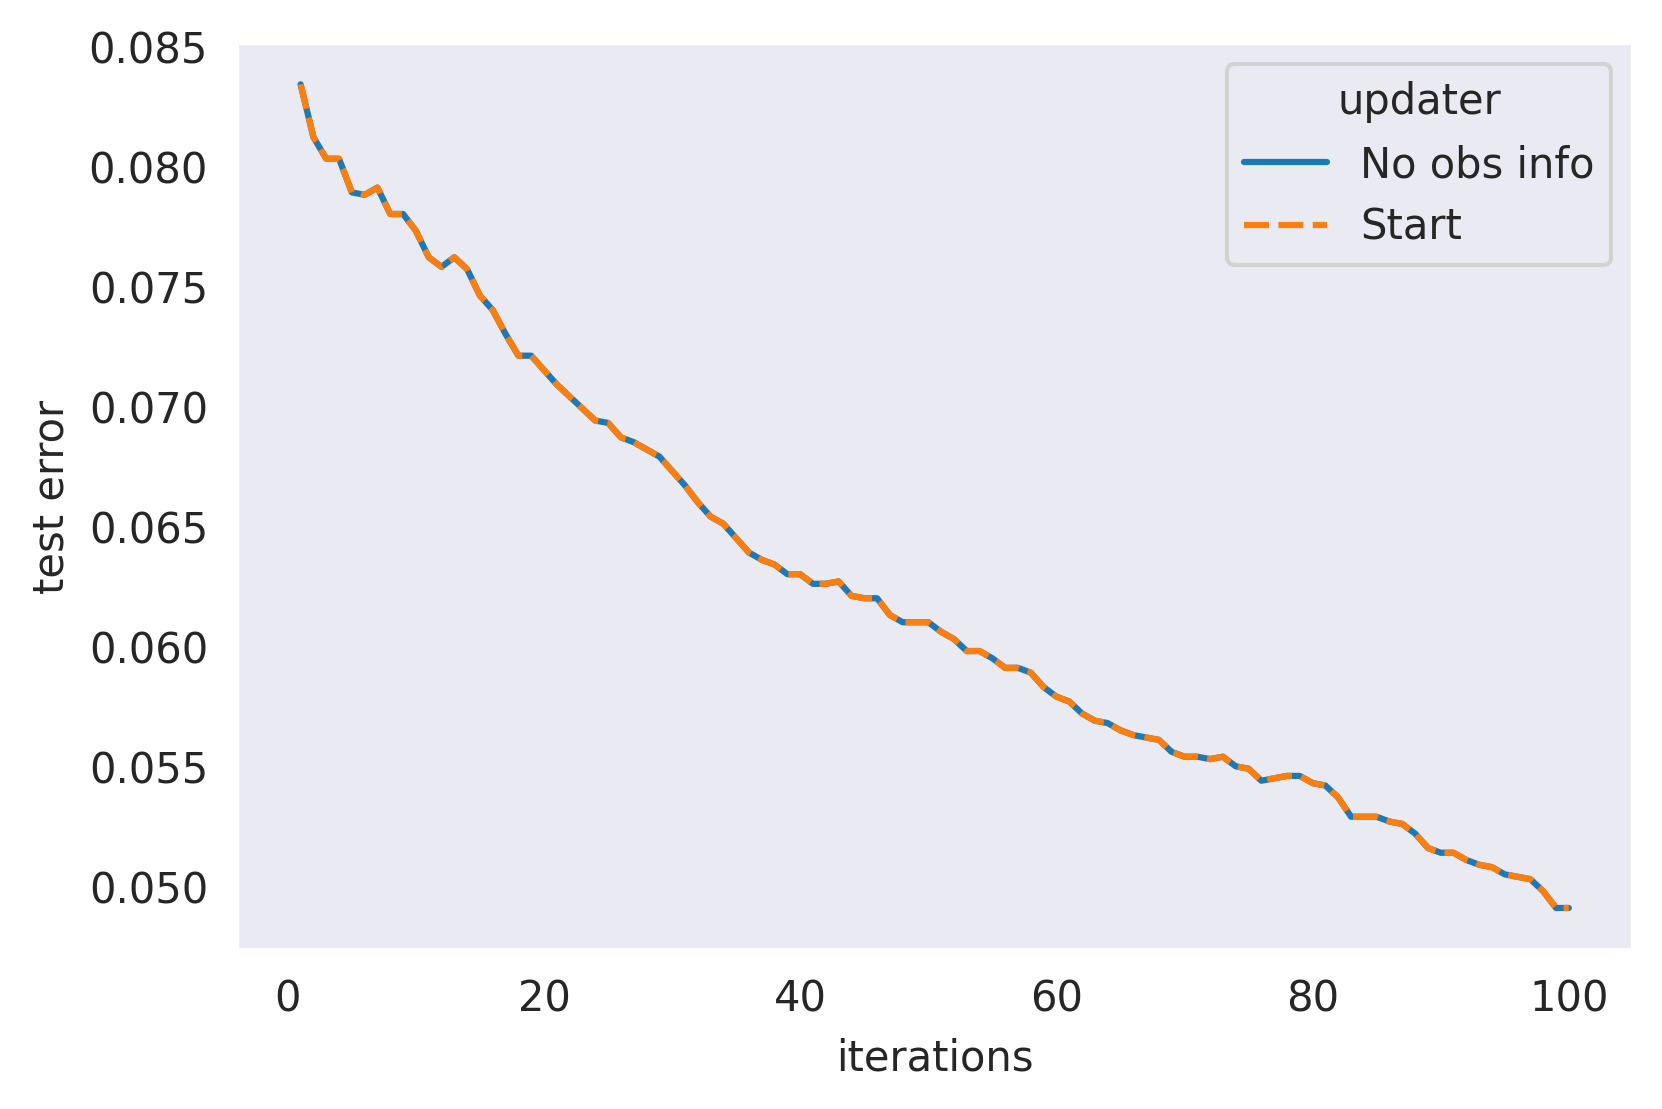

In [15]:
err_dict = {
    'No obs info' : noinfo_test_errs, 
    'Start' : start_test_errs, 
    # 'Every sample' : every_sample_test_errs, 
    # 'Every step' : every_step_test_errs
}
x = np.arange(1, NUM_EPOCHS+1)
lst = []
for i in range(len(x)):
    for updater in err_dict.keys():
        lst.append([x[i], updater, err_dict[updater][i]])

df = pd.DataFrame(lst, columns=['iterations', 'updater','test error'])
sns.lineplot(data=df.pivot("iterations", "updater", "test error"))
plt.ylabel("test error")
plt.show() #dpi=300

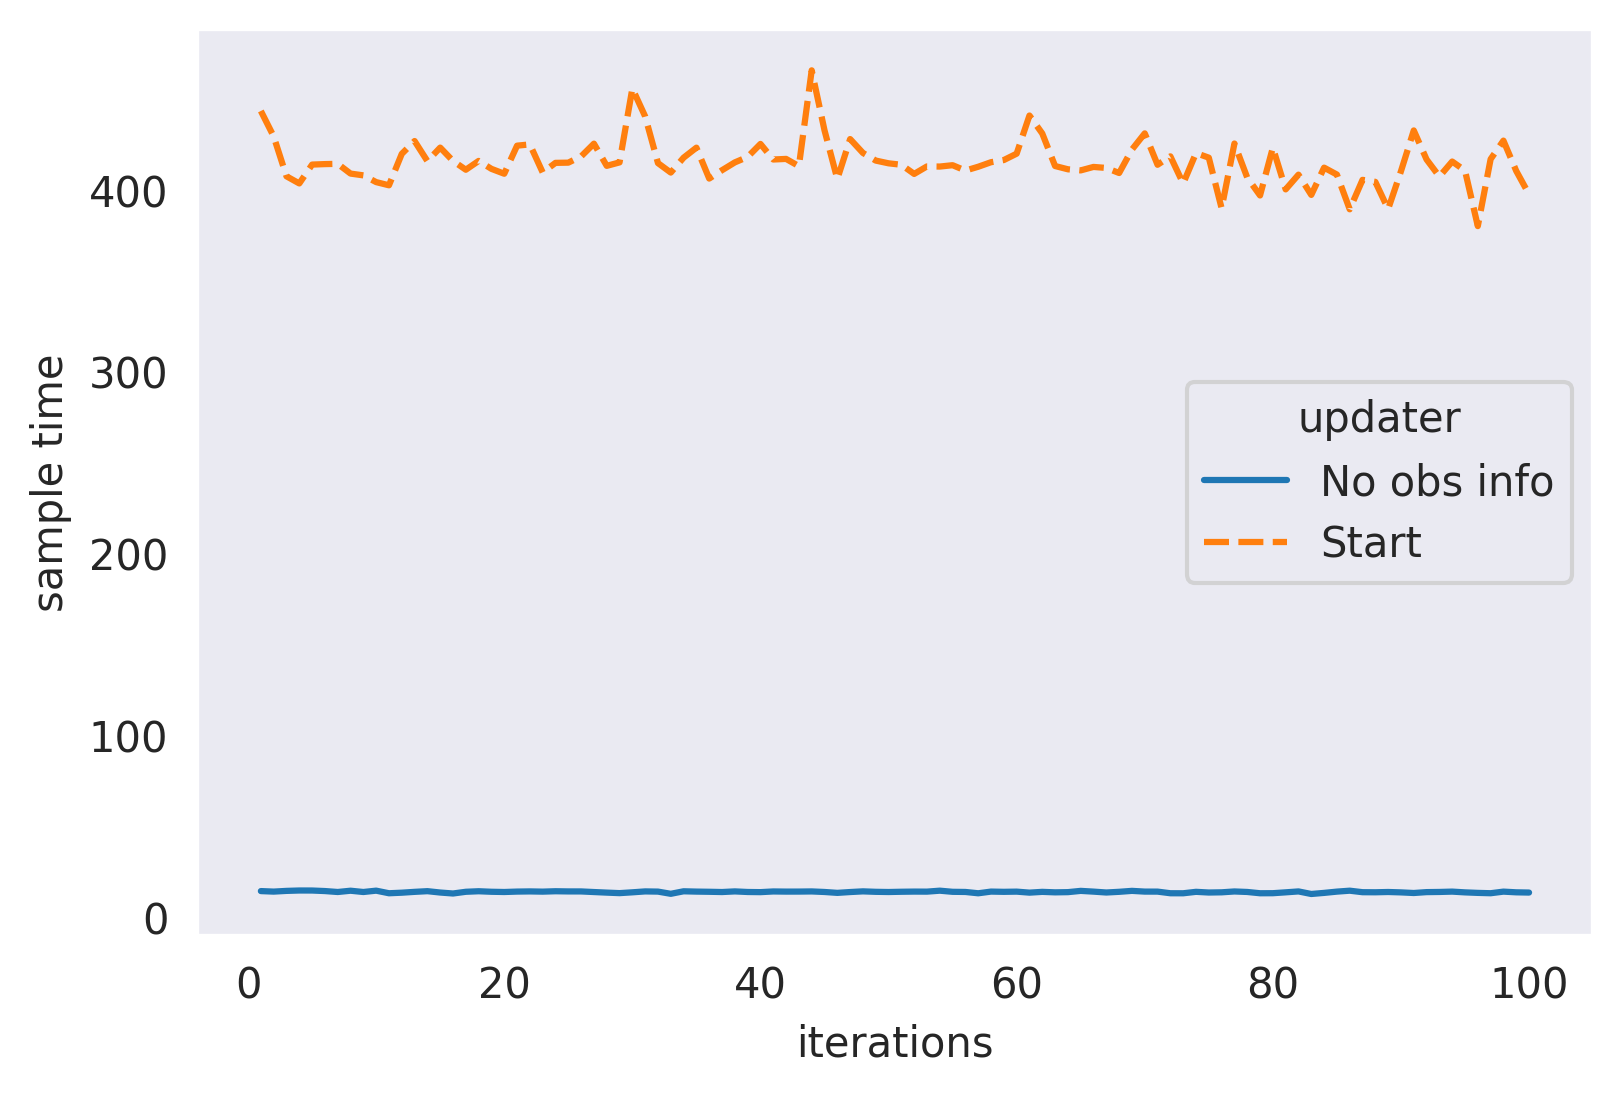

In [16]:
time_dict = {
    'No obs info' : noinfo_times, 
    'Start' : start_times, 
    # 'Every sample' : every_sample_times, 
    # 'Every step' : every_step_times
}
x = np.arange(1, NUM_EPOCHS+1)
lst = []
for i in range(len(x)):
    for updater in err_dict.keys():
        lst.append([x[i], updater, time_dict[updater][i]])

df = pd.DataFrame(lst, columns=['iterations', 'updater','sample time'])
sns.lineplot(data=df.pivot("iterations", "updater", "sample time"))
plt.ylabel("sample time")
plt.show() #dpi=300